In [10]:
import pandas as pd

# import src.sk_ml; reload(src.sk_ml)
# from src.sk_ml import *

import wKit.ML.sk_ml; reload(wKit.ML.sk_ml)
from wKit.ML.sk_ml import *
from wKit.utility.ipynb_helper import multi_column_df_display
from src.constants import fn_target_lts_dc, dir_data
from src.pred_lts import prepare_lts_dataset

%matplotlib inline

In [2]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(True)

In [3]:
fna = 0.0
years = (2014, 2015, 2016, 2017)
scaler_type = 'MinMaxScaler'
total_or_not = 'TOTAL'

In [4]:
datasets = {}
for total_or_not in ['NO_TOTAL', 'TOTAL']:
    print '=' * 20, 'loading data for', total_or_not
    scaler = scaler_by_name(scaler_type)
    ds = prepare_lts_dataset(scaler, fna, years, total_or_not, 'dict')
    datasets[total_or_not] = ds


==================== loading data for NO_TOTAL
loading feature and fill NAN
loading LTS and remove 10
creating train and test set
normalizing X
==================== loading data for TOTAL
loading feature and fill NAN
loading LTS and remove 10
creating train and test set
normalizing X


In [5]:
def ana_a_model(ds, model, param, kind, name, cv_dir):
    
    train_x, train_y, test_x, test_y, ftr_name = ds['train_x'], ds['train_y'], ds['test_x'], ds['test_y'], ds['ftr_name']
    
    grid_cv_a_model(train_x, train_y, model, param, kind, name, path=cv_dir, verbose=True)
    cfsn = confusion_matrix_as_df(model, test_x, test_y, labels=[1,2,3,4])
    imp = show_important_features(model, labels=ftr_name, top=10, set_std=True, show_plt=False)
    return cfsn, imp

In [7]:
res = {}
for total_or_not in ['TOTAL', 'NO_TOTAL']:
    cv_dir = 'data/cross_validation/na_{}-year_{}-total_{}-norm_{}'.format(fna, years, total_or_not, scaler_type)
    print '=' * 20, 'loading cv result from', cv_dir
    
    ds = datasets[total_or_not]
    train_x, train_y, test_x, test_y, ftr_name = ds['train_x'], ds['train_y'], ds['test_x'], ds['test_y'], ds['ftr_name']
    models = sk_models(stoplist=())
    params = grid_cv_default_params()

    kind = 'cls'
    
    name_rf = 'RFcls'
    print 'model =', name_rf
    model_rf, param_rf = models[kind][name_rf], params[kind][name_rf]
    cfsn_rf, imp_rf = ana_a_model(ds, model_rf, param_rf, kind, name_rf, cv_dir)
    
#     name_gbst = 'GDBcls'
#     print 'model =', name_gbst
#     model_gbst, param_gbst = models[kind][name_gbst], params[kind][name_gbst]
#     cfsn_gbst, imp_gbst = ana_a_model(ds, model_gbst, param_gbst, kind, name_gbst, cv_dir)
    
    res[total_or_not] = {
#         'gbst': model_gbst, 'cfsn_gbst': cfsn_gbst, 'imp_gbst': imp_gbst,
        'rf': model_rf, 'cfsn_rf': cfsn_rf, 'imp_rf': imp_rf,
    }


==================== loading cv result from data/cross_validation/na_0.0-year_(2014, 2015, 2016, 2017)-total_TOTAL-norm_MinMaxScaler
model = RFcls
loading existing model cls RFcls
fitting model cls RFcls
loaded existing result for model: RFcls
model = GDBcls
loading existing model cls GDBcls
fitting model cls GDBcls
loaded existing result for model: GDBcls
==================== loading cv result from data/cross_validation/na_0.0-year_(2014, 2015, 2016, 2017)-total_NO_TOTAL-norm_MinMaxScaler
model = RFcls
loading existing model cls RFcls
fitting model cls RFcls
loaded existing result for model: RFcls
model = GDBcls
loading existing model cls GDBcls
fitting model cls GDBcls
loaded existing result for model: GDBcls


# display confusion matrix

In [11]:
list_dfs = [
    res['TOTAL']['cfsn_rf'],
    res['NO_TOTAL']['cfsn_rf'],
    res['TOTAL']['cfsn_gbst'],
    res['NO_TOTAL']['cfsn_gbst'],
]
multi_column_df_display(list_dfs)

In [14]:
datasets['TOTAL'].keys()

['ftr_name', 'train_x', 'train_y', 'col2code', 'test_y', 'test_x']

In [20]:
t = 'TOTAL'
fitted_model = res[t]['rf']
test_x = datasets[t]['test_x']
test_x = pd.DataFrame(test_x, columns=datasets[t]['ftr_name'])
test_y = datasets[t]['test_y']
target_tp = [(2, 1), (2, 2)]


In [29]:

import wKit.ML.sk_ml; reload(wKit.ML.sk_ml)
from wKit.ML.sk_ml import *

In [30]:
a = get_idx_by_true_pred(fitted_model, test_x, test_y, target_tp)

In [31]:
ftr_diff_stat_test(fitted_model, test_x, test_y, target_tp)

,anova1way_p,anova1way_stat,kruskal_p,kruskal_stat,annova1way_siglv,kruskal_signlv
var_name,,,,,,
crash_total,2.523863e-27,131.726451,9.551702e-35,151.184418,***,***
poi_total,6.980830e-26,123.513923,5.065641e-28,120.440789,***,***
ud_clo_cntr_SgAsNd,2.667938e-24,114.625727,3.908431e-27,116.387982,***,***
ud_far_cntr_SgAsNd,1.071235e-18,84.175937,3.908431e-27,116.387982,***,***
d_far_cntr_SgAsNd,2.452133e-01,1.353440,4.859630e-26,111.390308,-,***
d_clo_cntr_SgAsNd,2.089586e-14,61.933302,4.305378e-24,102.503815,***,***
parking_total,5.465758e-11,44.883186,6.764341e-20,83.381756,***,***
d_node_ecc_SgAsNd,6.088596e-14,59.580934,4.725314e-18,74.992392,***,***
crime_total,2.642965e-12,51.374863,1.877274e-16,67.727495,***,***


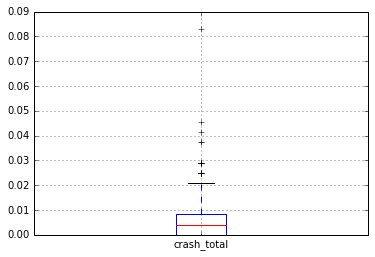

In [38]:
test_x.iloc[a[(2,1)]].crash_total.to_frame().boxplot()

# display feature importances

In [32]:
list_dfs = [
    res['TOTAL']['imp_rf'],
    res['TOTAL']['imp_gbst'],
]
multi_column_df_display(list_dfs, cols=2)

,importance,label,std
32,0.065753,crash_total,0.026464
38,0.047832,poi_total,0.019029
61,0.042871,moving_total,0.020070
55,0.036657,ud_far_cntr_SgAsNd,0.009871
52,0.036549,ud_clo_cntr_SgAsNd,0.009422
6,0.036204,STREETTYPE_AVE,0.013923
42,0.035803,d_far_cntr_SgAsNd,0.008532
41,0.035331,d_clo_cntr_SgAsNd,0.008917
45,0.034933,d_node_ecc_SgAsNd,0.008535
0,0.034613,SHAPE_Length,0.004367


In [33]:
list_dfs = [
    res['NO_TOTAL']['imp_rf'],
    res['NO_TOTAL']['imp_gbst'],
]
multi_column_df_display(list_dfs, cols=2)

,importance,label,std
64,0.051759,FIRSTHARMFULEVENTSPECIFICS_Motor Vehicle In Tr...,0.042702
36,0.040820,CRASHEVENTTYPES_COLLISION_WITH_NON_FIXED,0.039625
6,0.040347,STREETTYPE_AVE,0.010575
34,0.026831,CRASHEVENTTYPES_ PENDING_INVESTIGATION,0.033419
574,0.026712,Existing Bike Lane,0.007321
161,0.024630,retail shop,0.011339
175,0.022486,d_node_ecc_SgAsNd,0.007058
0,0.019240,SHAPE_Length,0.003486
152,0.017877,TRAFFIC SIGNAL MAIN,0.020968
187,0.017845,ud_node_ecc_SgAsNd,0.004167


# bar chart feature importances

In [82]:
imp_rf = res['NO_TOTAL']['imp_rf']
imp_gbst = res['NO_TOTAL']['imp_gbst']
print 'in rf not gbst', set(imp_rf.label) - set(imp_gbst.label)
print 'in gbst not rf', set(imp_gbst.label) - set(imp_rf.label)
data = [
    go.Bar(x=imp_rf.importance, y=imp_rf.label,  error_x=dict(array=imp_rf['std']), orientation='h', name='rf'),
    go.Bar(x=imp_gbst.importance, y=imp_gbst.label,  error_x=dict(array=imp_gbst['std']), orientation='h', name='gbst'),
    
]
layout = go.Layout(margin=go.Margin(l=300))
fig = go.Figure(data=data, layout=layout)

iplot(fig)

in rf not gbst set(['retail shop', 'd_node_ecc_SgAsNd', 'CRASHEVENTTYPES_ PENDING_INVESTIGATION', 'TRAFFIC SIGNAL MAIN'])
in gbst not rf set(['ud_clo_cntr_SgAsNd', 'ud_far_cntr_SgAsNd', 'd_page_rank_SgAsNd', 'ud_page_rank_SgAsNd'])


In [83]:
imp_rf = res['TOTAL']['imp_rf']
imp_gbst = res['TOTAL']['imp_gbst']
print 'in rf not gbst', set(imp_rf.label) - set(imp_gbst.label)
print 'in gbst not rf', set(imp_gbst.label) - set(imp_rf.label)

data = [
    go.Bar(x=imp_rf.importance, y=imp_rf.label,  error_x=dict(array=imp_rf['std']), orientation='h', name='rf'),
    go.Bar(x=imp_gbst.importance, y=imp_gbst.label,  error_x=dict(array=imp_gbst['std']), orientation='h', name='gbst'),
    
]
layout = go.Layout(margin=go.Margin(l=200))
fig = go.Figure(data=data, layout=layout)

iplot(fig)

in rf not gbst set(['d_node_ecc_SgAsNd'])
in gbst not rf set(['d_btw_cntr_SgAsNd'])
